#  Práctica Obligatoria - Parte III - CNN

***<p style="text-align:center;">Aprendizaje Automático II</p>***
***<p style="text-align:center;">CNNs</p>***

En esta parte, entrenarás varias redes CNNs y analizarás sus resultados en el dataset GTS.


### Evaluación - 4/10 puntos

Puntuación de cada parte sobre el total de la práctica:
- **[Ejercicio 1]** 0.25 puntos.
- **[Ejercicio 2]** 0.25 puntos.
- **[Ejercicio 3]** 0.5 puntos.
- **[Ejercicio 4]** 3 puntos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

from gts_dataset import GTS


In [2]:
!unzip /content/data.zip -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: /content/data/test_prepared/06646.png  
 extracting: /content/data/test_prepared/08013.png  
 extracting: /content/data/test_prepared/05006.png  
 extracting: /content/data/test_prepared/01747.png  
 extracting: /content/data/test_prepared/08006.png  
 extracting: /content/data/test_prepared/03231.png  
 extracting: /content/data/test_prepared/05240.png  
 extracting: /content/data/test_prepared/03732.png  
 extracting: /content/data/test_prepared/09868.png  
 extracting: /content/data/test_prepared/05120.png  
 extracting: /content/data/test_prepared/12523.png  
 extracting: /content/data/test_prepared/10590.png  
 extracting: /content/data/test_prepared/11227.png  
 extracting: /content/data/test_prepared/04026.png  
 extracting: /content/data/test_prepared/06894.png  
 extracting: /content/data/test_prepared/06080.png  
 extracting: /content/data/test_prepared/12147.png  
 extracting: /content/data/test_prepar

## Importa las funciones que has creado desde `utils.py`:

In [3]:
from utils import count_trainable_params, train, evaluate, train_and_evaluate, save_full_model, load_full_model, plot_loss_accuracy, plot_confusion_matrix, plot_error_per_class

## Carga el dataset GTS  y crea los dataloaders:

In [4]:
# Definir las transformaciones y conversión a tensor
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## **[Ejercicio 1]** Crea un modelo `CNN` con las siguientes características:

1. Tres bloques convolucionales (conv2d -> batch norm -> ReLU).
2. Flatten para aplanar características.
3. Una capa densa para clasificación.
4. Comprueba el número de parámetros entrenables y busca una configuración que no supere los **50.000** parámetros (aproximadamente 4 veces menos que la MLP).

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Pooling global
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Capa totalmente conectada
        self.fc = nn.Linear(in_features=64, out_features=output_dim)

    def forward(self, x):
        # Primer bloque convolucional
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Segundo bloque convolucional
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Tercer bloque convolucional
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Pooling global
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Capa totalmente conectada
        x = self.fc(x)

        # Softmax para clasificación
        x = F.log_softmax(x, dim=1)

        return x

# Contar parámetros entrenables
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calcular parámetros del modelo ajustado
cnn_model = CNN(output_dim=43)
print("Número de parámetros entrenables:", count_trainable_params(cnn_model))


Número de parámetros entrenables: 26603


In [6]:
with open("models.py", "a") as file:
    file.write('''

# Red neuronal CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, output_dim):
        super(CNN, self).__init__()

        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Pooling global
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Capa totalmente conectada
        self.fc = nn.Linear(in_features=64, out_features=output_dim)

    def forward(self, x):
        # Primer bloque convolucional
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Segundo bloque convolucional
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Tercer bloque convolucional
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Pooling global
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Capa totalmente conectada
        x = self.fc(x)

        # Softmax para clasificación
        x = F.log_softmax(x, dim=1)

        return x

  ''')


Guarda el modelo en `models.py`

### Entrena el modelo CNN con las funciones que has importado y analiza los resultados:

In [7]:
#import matplotlib.pyplot as plt

# Instancia el modelo
model_cnn = CNN(output_dim=43)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='cnn'
train_loss_df, val_loss_df, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(
    model_cnn, train_loader, valid_loader, test_loader, optimizer, device, num_epochs=10, name='cnn'
)
# Guarda el modelo con file_name='cnn.pth'
save_full_model(model_cnn, file_name='cnn.pth')

# Carga los datos y muéstralos
train_loss_file = 'train_loss_cnn.csv'
valid_loss_file = 'valid_loss_cnn.csv'
train_accuracy_file = 'train_accuracy_cnn.csv'
valid_accuracy_file = 'valid_accuracy_cnn.csv'

#plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)#

# Calcula la matriz de confusión
#cm = plot_confusion_matrix(model_cnn, test_loader, device=device)

# Muestra el porcentaje de error por clase
#plot_error_per_class(cm)


Epoch [1/10], Train Loss: 2.1076, Train Accuracy: 0.4231, Validation Loss: 1.5240, Validation Accuracy: 0.5210
Epoch [2/10], Train Loss: 1.0229, Train Accuracy: 0.7162, Validation Loss: 0.8049, Validation Accuracy: 0.7834
Epoch [3/10], Train Loss: 0.6177, Train Accuracy: 0.8394, Validation Loss: 0.6355, Validation Accuracy: 0.7935
Epoch [4/10], Train Loss: 0.4307, Train Accuracy: 0.8949, Validation Loss: 0.4120, Validation Accuracy: 0.9011
Epoch [5/10], Train Loss: 0.3121, Train Accuracy: 0.9239, Validation Loss: 0.2987, Validation Accuracy: 0.9222
Epoch [6/10], Train Loss: 0.2440, Train Accuracy: 0.9414, Validation Loss: 0.2360, Validation Accuracy: 0.9475
Epoch [7/10], Train Loss: 0.1976, Train Accuracy: 0.9525, Validation Loss: 0.1991, Validation Accuracy: 0.9449
Epoch [8/10], Train Loss: 0.1614, Train Accuracy: 0.9609, Validation Loss: 0.1587, Validation Accuracy: 0.9660
Epoch [9/10], Train Loss: 0.1372, Train Accuracy: 0.9673, Validation Loss: 0.1401, Validation Accuracy: 0.9660
E

Describe las diferencias en los resultados que has obtenido.

############## COMPLETAR ##############

############ Fin COMPLETAR ############

## **[Ejercicio 2]** Dataset permutado: re-entrena la MLP y la CNN

Esta vez, vuelve a entrenar la `MLP`y la `CNN` que has configurado pero con el mismo dataset modificado.

Esta modificación consiste en permutar los píxeles de las imágenes siempre de la misma manera.


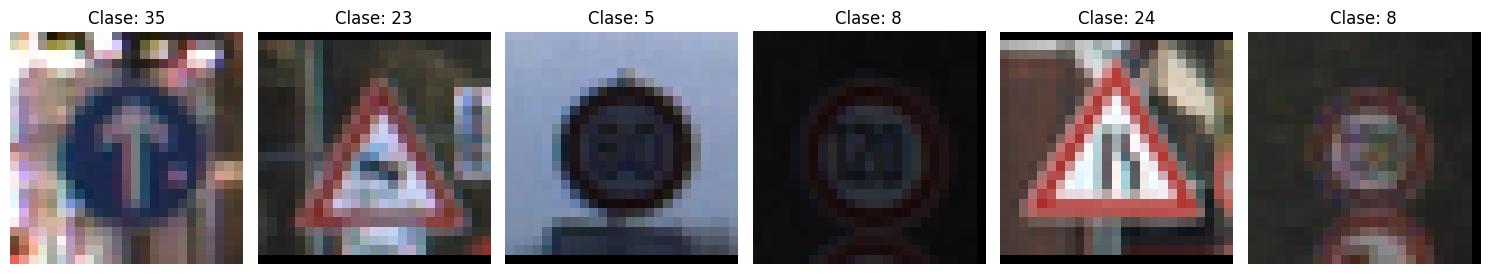

In [8]:
def visualize_subset(dataset, num_images=6):
    """
    Visualiza ejemplos directamente de un Subset o Dataset.

    :param dataset: Dataset o Subset que contiene las imágenes y etiquetas.
    :param num_images: Número de imágenes a mostrar.
    """
    indices = np.arange(num_images)
    images = []
    labels = []

    for idx in indices:
        image, label = dataset[idx]
        images.append(image)
        labels.append(label)

    images = torch.stack(images)  # Convertir la lista de imágenes en un tensor
    images = images.permute(0, 2, 3, 1).numpy()


    # Mostrar imágenes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx in range(num_images):
        axes[idx].imshow(images[idx])
        axes[idx].set_title(f"Clase: {labels[idx]}")
        axes[idx].axis('off')
    plt.tight_layout()
    plt.show()


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


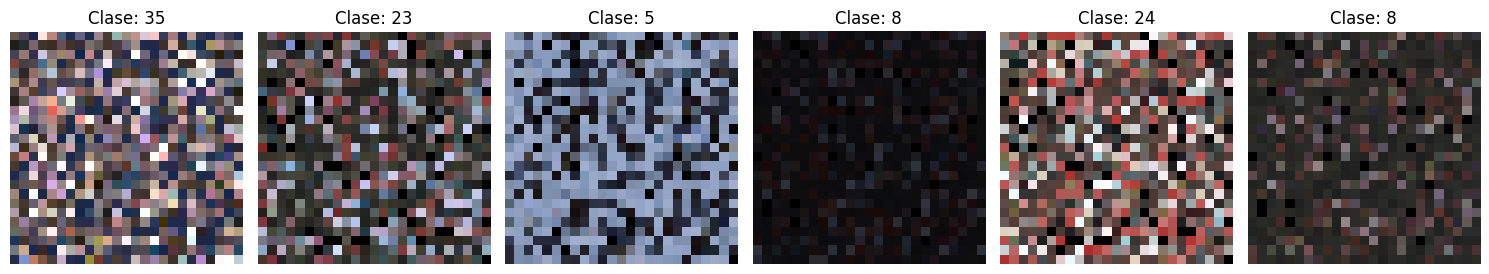

In [9]:
class ShufflePixels:
    def __init__(self, seed=42):
        """
        Inicializa la transformación de shuffle de píxeles.
        Args:
            seed (int): Semilla para generar una permutación fija.
        """
        self.seed = seed
        torch.manual_seed(self.seed)  # Fijar la semilla
        self.permutation = None

    def __call__(self, img):
        """
        Aplica la permutación a los píxeles de la imagen.
        Args:
            img (torch.Tensor): Imagen en formato (C, H, W).
        Returns:
            torch.Tensor: Imagen con píxeles permutados.
        """
        C, H, W = img.shape  # Extraer dimensiones de la imagen

        if self.permutation is None:
            # Generar permutación fija
            self.permutation = torch.randperm(H * W)  # Permutación fija en 1D

        # Aplanar la imagen, permutar y restaurar forma original
        img = img.view(C, H * W)  # (C, H * W)
        img = img[:, self.permutation]  # Aplicar la permutación
        img = img.view(C, H, W)  # Restaurar la forma original
        return img

# Definir las transformaciones con shuffle de píxeles
transform = transforms.Compose([
    transforms.ToTensor(),
    ShufflePixels(seed=42)  # Aplicar shuffle fijo
])
train_dataset_shuffle = GTS(csv_file='train.csv', root_dir='./data', transform=transform)
valid_dataset_shuffle = GTS(csv_file='valid.csv', root_dir='./data', transform=transform)
test_dataset_shuffle = GTS(csv_file='test.csv', root_dir='./data', transform=transform)

device = 'cpu'
batch_size = 16

train_loader_shuffle = DataLoader(train_dataset_shuffle, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader_shuffle = DataLoader(valid_dataset_shuffle, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_shuffle = DataLoader(test_dataset_shuffle, batch_size=batch_size, shuffle=False, num_workers=4)


# Visualizar ejemplos del conjunto de entrenamiento
visualize_subset(train_dataset_shuffle)

### Entrena la MLP con:

* `train_loader_shuffle`
* `valid_loader_shuffle`
* `test_loader_shuffle`

Guarda el modelo como `mlp_shuffle.pth` y los resultados de `loss` y `accuracy`con la misma extensión:

Tamaño de la salida: torch.Size([16, 43])
Epoch [1/10], Train Loss: 1.9455, Train Accuracy: 0.4291, Validation Loss: 1.1267, Validation Accuracy: 0.6584
Epoch [2/10], Train Loss: 0.8950, Train Accuracy: 0.7236, Validation Loss: 0.7289, Validation Accuracy: 0.7723
Epoch [3/10], Train Loss: 0.6384, Train Accuracy: 0.8032, Validation Loss: 0.4980, Validation Accuracy: 0.8486
Epoch [4/10], Train Loss: 0.4925, Train Accuracy: 0.8466, Validation Loss: 0.4168, Validation Accuracy: 0.8763
Epoch [5/10], Train Loss: 0.4195, Train Accuracy: 0.8705, Validation Loss: 0.4936, Validation Accuracy: 0.8485
Epoch [6/10], Train Loss: 0.3543, Train Accuracy: 0.8921, Validation Loss: 0.7104, Validation Accuracy: 0.8086
Epoch [7/10], Train Loss: 0.3172, Train Accuracy: 0.9035, Validation Loss: 0.3257, Validation Accuracy: 0.9049
Epoch [8/10], Train Loss: 0.2808, Train Accuracy: 0.9122, Validation Loss: 0.3576, Validation Accuracy: 0.8877
Epoch [9/10], Train Loss: 0.2580, Train Accuracy: 0.9182, Validation L

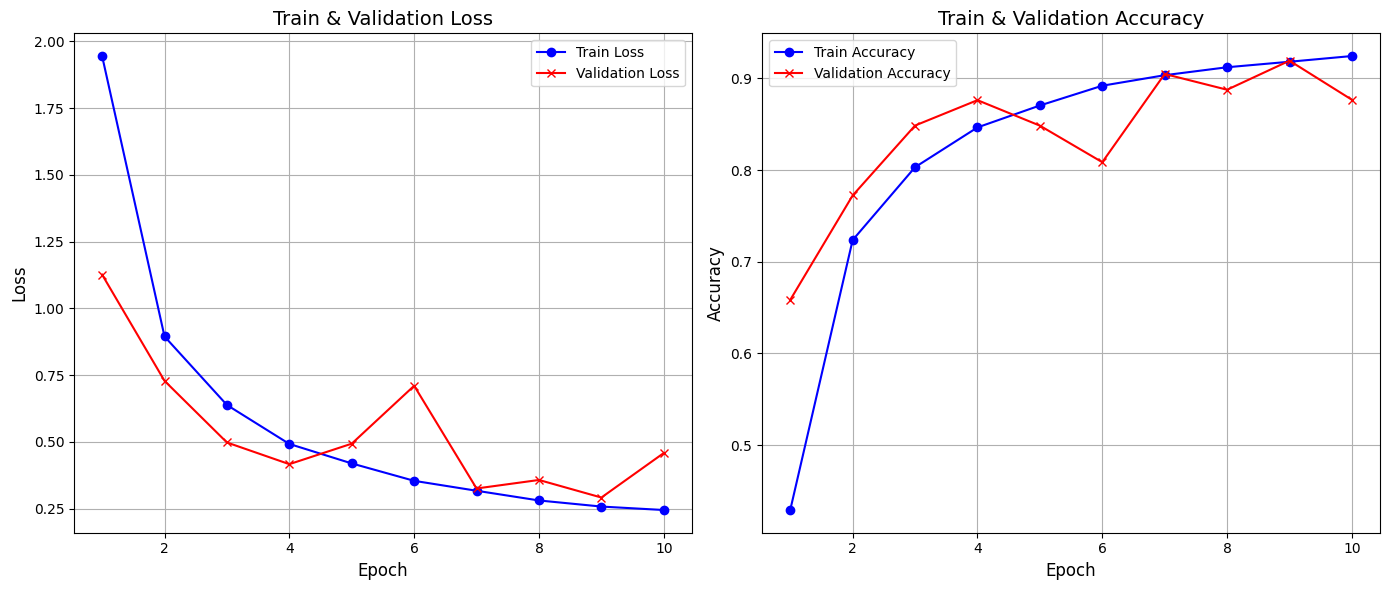

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


NameError: name 'sns' is not defined

<Figure size 1000x700 with 0 Axes>

In [10]:
from models import MLP

# Instancia el modelo
input_size = 3 * 25 * 25  # Producto de los canales y dimensiones de la imagen
hidden_size = 512  # Tamaño de la capa oculta
output_size = 43    # Número de clases de salida (en tu caso, 43 clases)

# Instancia el modelo
model_mlp = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer =  torch.optim.Adam(model_mlp.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='mlp_shuffle'
train_loss_df, val_loss_df, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(model_mlp, train_loader_shuffle, valid_loader_shuffle, test_loader_shuffle, optimizer, device, num_epochs, name='mlp_shuffle')




# Guarda el modelo. Usa file_name='mlp_shuffle.pth'
save_full_model(model_mlp, file_name='mlp_shuffle.pth')


# Carga los datos y muéstralos
train_loss_file = 'train_loss_mlp_shuffle.csv'
valid_loss_file = 'valid_loss_mlp_shuffle.csv'
train_accuracy_file = 'train_accuracy_mlp_shuffle.csv'
valid_accuracy_file = 'valid_accuracy_mlp_shuffle.csv'

# plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# # Calcula la matriz de confusión
# cm = plot_confusion_matrix(model_mlp, test_loader_shuffle, device=device)

# # Muestra el porcentaje de error por clase
# plot_error_per_class(cm)


### Entrena la CNN con:

* `train_loader_shuffle`
* `valid_loader_shuffle`
* `test_loader_shuffle`

Guarda el modelo como `cnn_shuffle.pth` y los resultados de `loss`y `accuracy` con la misma extensión:

In [ ]:
# Instancia el modelo
model_cnn = CNN(output_dim=43)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='cnn_shuffle'
train_loss_df, val_loss_df, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(model_cnn, train_loader_shuffle, valid_loader_shuffle, test_loader_shuffle, optimizer, device, num_epochs, name='cnn_shuffle')




# Guarda el modelo. Usa file_name='cnn_shuffle.pth'
save_full_model(model_cnn, file_name='cnn_shuffle.pth')


# Carga los datos y muéstralos
train_loss_file = 'train_loss_cnn_shuffle.csv'
valid_loss_file = 'valid_loss_cnn_shuffle.csv'
train_accuracy_file = 'train_accuracy_cnn_shuffle.csv'
valid_accuracy_file = 'valid_accuracy_cnn_shuffle.csv'

# plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# # Calcula la matriz de confusión
# cm = plot_confusion_matrix(model_cnn, test_loader_shuffle, device=device)

# # Muestra el porcentaje de error por clase
# plot_error_per_class(cm)

Epoch [1/10], Train Loss: 2.8370, Train Accuracy: 0.2099, Validation Loss: 2.4038, Validation Accuracy: 0.2745


¿Cómo podrías explicar los resultados?

############## COMPLETAR ##############

############ Fin COMPLETAR ############

## **[Ejercicio 3]** Entrena una `FCNN` con las siguientes características:

1. Cuatro bloques convolucionales (conv2d -> batch norm -> ReLU).
2. Un bloque convolucional final con tantas características como clases haya (43)
3. Comprueba el número de parámetros entrenables y busca una configuración que no supere los **50.000** parámetros (aproximadamente 4 veces menos que la MLP).

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNN(nn.Module):
    def __init__(self, output_dim):
        super(FCNN, self).__init__()

        # Primer bloque convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)

        # Segundo bloque convolucional
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Tercer bloque convolucional
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Cuarto bloque convolucional
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Bloque final convolucional
        self.conv_out = nn.Conv2d(in_channels=64, out_channels=output_dim, kernel_size=1)

    def forward(self, x):
        # Primer bloque convolucional
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Segundo bloque convolucional
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        # Tercer bloque convolucional
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)

        # Cuarto bloque convolucional
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)

        # Bloque final convolucional
        x = self.conv_out(x)  # Salida (N, output_dim, H, W)
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Reduce a (N, output_dim, 1, 1)
        x = torch.flatten(x, 1)  # Achata a (N, output_dim)
        return x

# Función para contar parámetros entrenables
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Creación del modelo y cálculo de parámetros
output_dim = 43
model = FCNN(output_dim=output_dim)
print("Parámetros entrenables:", count_trainable_params(model))


Parámetros entrenables: 27563


Añade el modelo a tu archivo `models.py`.

### Entrena la FCNN con el dataset original (sin permutar)

* `train_loader`
* `valid_loader`
* `test_loader`

Guarda el modelo como `fcnn.pth` y los resultados de `loss`y `accuracy` con la misma extensión:

In [18]:
# Instancia el modelo
model_fcnn = FCNN(output_dim=43)

# Instancia la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcnn.parameters(), lr=0.001)

# Fija 10 épocas
num_epochs = 10

# Entrena y evalua el modelo. Usa name='fcnn'
train_loss_df, val_loss_df, train_accuracies, val_accuracies, test_loss, test_accuracy = train_and_evaluate(model_fcnn, train_loader, valid_loader, test_loader, optimizer, device, num_epochs, name='fcnn')




# Guarda el modelo. Usa file_name='fcnn.pth'
save_full_model(model_fcnn, file_name='fcnn.pth')


# Carga los datos y muéstralos
train_loss_file = 'train_loss_fcnn.csv'
valid_loss_file = 'valid_loss_fcnn.csv'
train_accuracy_file = 'train_accuracy_fcnn.csv'
valid_accuracy_file = 'valid_accuracy_fcnn.csv'

# plot_loss_accuracy(train_loss_file, valid_loss_file, train_accuracy_file, valid_accuracy_file)

# # Calcula la matriz de confusión
# cm = plot_confusion_matrix(model_fcnn, test_loader, device=device)

# # Muestra el porcentaje de error por clase
# plot_error_per_class(cm)

Epoch [1/10], Train Loss: 2.9179, Train Accuracy: 0.2039, Validation Loss: 2.4152, Validation Accuracy: 0.3146
Epoch [2/10], Train Loss: 2.1512, Train Accuracy: 0.3610, Validation Loss: 1.8740, Validation Accuracy: 0.4012
Epoch [3/10], Train Loss: 1.7175, Train Accuracy: 0.4709, Validation Loss: 1.4257, Validation Accuracy: 0.5420
Epoch [4/10], Train Loss: 1.4117, Train Accuracy: 0.5693, Validation Loss: 1.2492, Validation Accuracy: 0.6154
Epoch [5/10], Train Loss: 1.1408, Train Accuracy: 0.6636, Validation Loss: 1.0425, Validation Accuracy: 0.6751
Epoch [6/10], Train Loss: 0.9198, Train Accuracy: 0.7374, Validation Loss: 0.8445, Validation Accuracy: 0.7493
Epoch [7/10], Train Loss: 0.7461, Train Accuracy: 0.7913, Validation Loss: 0.6438, Validation Accuracy: 0.8214
Epoch [8/10], Train Loss: 0.6060, Train Accuracy: 0.8353, Validation Loss: 0.5628, Validation Accuracy: 0.8510
Epoch [9/10], Train Loss: 0.4973, Train Accuracy: 0.8669, Validation Loss: 0.4410, Validation Accuracy: 0.8703
E

# **[Ejercicio 4]** Reto final: entrena el mejor modelo que puedas.

1. Crea un modelo con las características que quieras siempre y cuando no supere los **200.000** parámetros.
2. Entrena con el optimizador y estrategias (`learning rate schedulers`, `normalization`, etc) que quieras, siempre y cuando no entrenes más de **10 épocas**.
3. Puedes normalizar los datos y hacer data-augmentation.
4. Guarda el modelo en tu archivo `models.py` y llámalo: `MyBestModel`.

In [ ]:
class MyBestModel(nn.Module):
    def __init__(self, output_dim):
        super(MyBestModel, self).__init__()

        # Bloques convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(24)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=160, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(160)

        # Capa Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Inicialización diferida para la capa lineal
        self.fc = None
        self.output_dim = output_dim

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)

        # Inicializar la capa totalmente conectada dinámicamente
        if self.fc is None:
            self.fc = nn.Linear(x.size(1), self.output_dim).to(x.device)

        x = self.fc(x)
        return x


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

def train_and_evaluate(model, train_dataset, val_dataset, epochs=10, batch_size=32, learning_rate=0.001):
    # Definimos el dispositivo (GPU si está disponible)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Configuramos el DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Definimos el optimizador y el criterio de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Inicializamos listas para guardar métricas
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # === Fase de entrenamiento ===
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward y cálculo de pérdida
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # === Fase de validación ===
        model.eval()
        val_loss = 0.0
        all_targets = []
        all_preds = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward y cálculo de pérdida
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()

                # Cálculo de precisión
                _, preds = torch.max(outputs, 1)
                all_targets.extend(targets.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = accuracy_score(all_targets, all_preds)
        val_accuracies.append(val_accuracy)

        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Métricas finales
    metrics = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
    }

    return metrics


In [ ]:
def test_model(model, test_dataset, batch_size=32):
    # Definimos el dispositivo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Configuramos el DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward
            outputs = model(inputs)

            # Predicciones
            _, preds = torch.max(outputs, 1)
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Cálculo de precisión
    test_accuracy = accuracy_score(all_targets, all_preds)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


In [ ]:
# Dataset simulados (reemplaza con tus datasets reales)
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Normalización y data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
val_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Crear modelo
model = MyBestModel(output_dim=10)  # CIFAR10 tiene 10 clases

# Entrenar y evaluar
metrics = train_and_evaluate(model, train_data, val_data, epochs=10, batch_size=64, learning_rate=0.001)

# Probar el modelo
test_model(model, test_data)
